# Email Classififaction 

In [51]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np

In [106]:
# Import the data
data = pd.read_csv('combined_data.csv')

/var/folders/zm/87wl1bb92s16mph31dwf4s5c0000gn/T/ipykernel_15024/676033433.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('combined_data.csv')


## Preliminary Data Processing step 


This includes loading the combined dataset, preprocessing text data, and preparing it for model training. There are columns for sender, receiver, date, subject, body, label, and urls. The label column appears to be a binary indicator where 1 might represent a phishing email, and the urls column indicates the presence of URLs in the email body, which is also marked as 1 for the presence of URLs. We want to preprocess both the subject and body as both of these fields carry significant information that can contribute to the classification performance.

In [25]:
# print the shape of the data
print(data.shape)

(145639, 7)


- For the 'subject' and 'body' columns, any NaN values are replaced with empty strings (''). This approach handles cases where emails might lack a subject or body without removing these rows from the dataset.
- For the 'label' column, NaN values are replaced with 0. This implies that any email without a specified label (indicating whether it is phishing or not) is defaulted to '0', which  represents the 'Non-Phishing' class.


In [107]:
# Fill NaN values
data.fillna({'subject': '', 'body': '', 'label': 0}, inplace=True)

This code creates a new column in the DataFrame called `url_present`. It evaluates whether each entry in the 'urls' column is not empty. This returns a boolean value, where True indicates that there is data present in the 'urls' column. It then converts this boolean value into intergers (1 representing True and 0 representing False)

In [108]:
# Handle 'urls' column: Create a binary flag indicating the presence of URLs
data['urls_present'] = data['urls'].notna().astype(int)

print(data['urls_present'].value_counts())

urls_present
1    113013
0     32626
Name: count, dtype: int64


## Raw Data Visualisation

To visualise the CSV file, we need to do catergorise the data in a few ways:

- Distribution of labels: Show the balance between phishing and non-phishing emails
- Presence of URLs in phishing vs. non-phishing emails: A comparison to see if phishing emails are more likely to contain URLs

1. Distribution of labels 

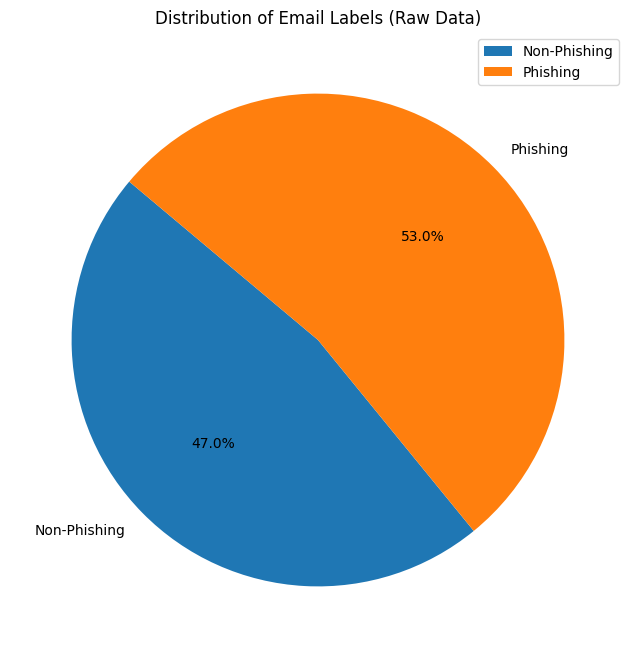

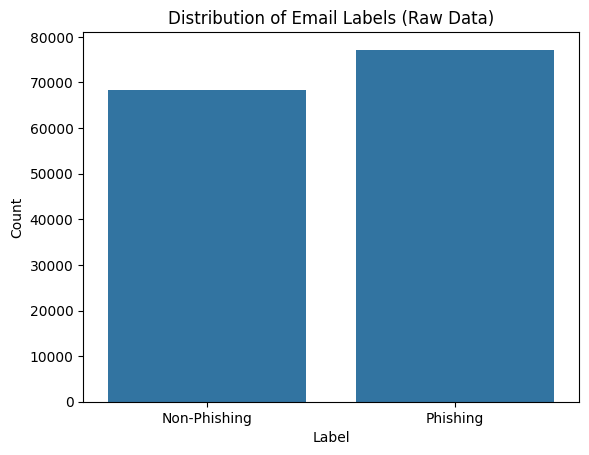

In [109]:
# Show the pie chart
non_phishing_count = data[data['label'] == 0].shape[0]
phishing_count = data[data['label'] == 1].shape[0]
counts = [non_phishing_count, phishing_count]
labels = ['Non-Phishing', 'Phishing']
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Email Labels (Raw Data)')
plt.legend(loc="best")

# Show the bar chart 
plt.show()
sns.countplot(x='label', data=data)
plt.title('Distribution of Email Labels (Raw Data)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Phishing', 'Phishing'])
plt.show()

2. Presence of URLs in Phishing vs. Non-Phishing Emails

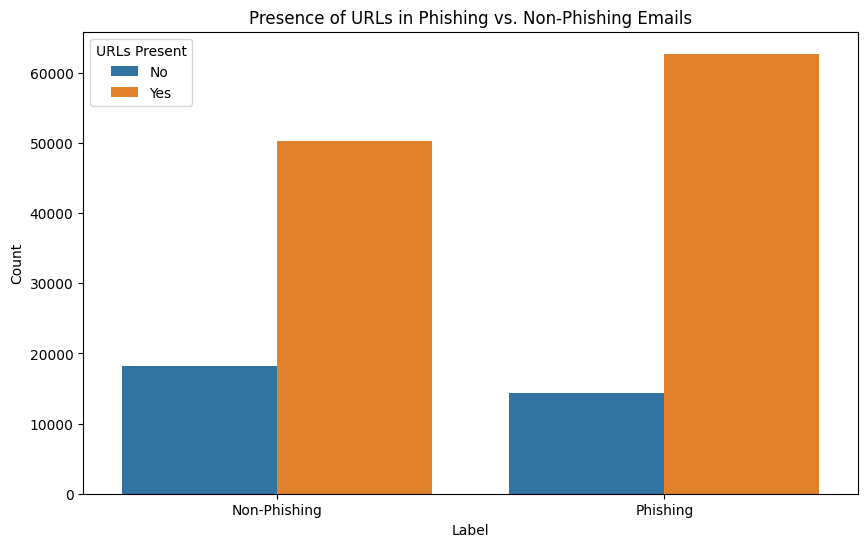

In [110]:
# Now plot using 'urls_present' instead of 'urls'
plt.figure(figsize=(10, 6))
sns.countplot(x='label', hue='urls_present', data=data)
plt.title('Presence of URLs in Phishing vs. Non-Phishing Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Phishing', 'Phishing'])
plt.legend(title='URLs Present', labels=['No', 'Yes'])
plt.show()



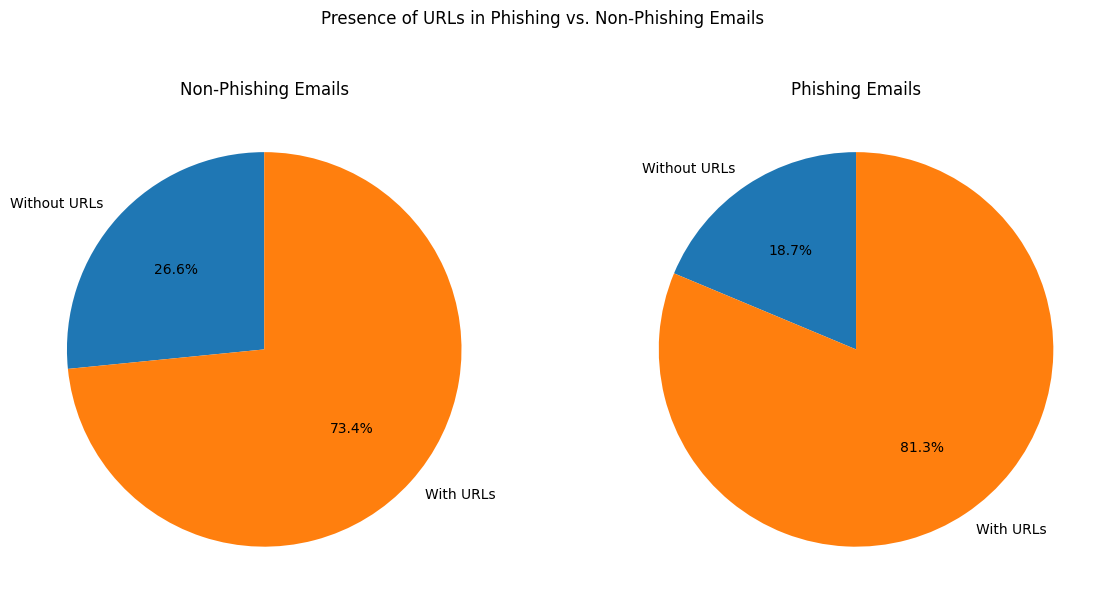

In [112]:
# Calculate the count of emails for each combination of 'label' and 'urls_present'
grouped_counts = data.groupby(['label', 'urls_present']).size().unstack(fill_value=0)

# Calculate percentages
percentages = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Labels for the slices
labels = ['Without URLs', 'With URLs']  # Adjust these labels to match your 'urls_present' categories

# Non-Phishing Emails Pie Chart
axes[0].pie(percentages.loc[0], labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Non-Phishing Emails')

# Phishing Emails Pie Chart
axes[1].pie(percentages.loc[1], labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Phishing Emails')

plt.suptitle('Presence of URLs in Phishing vs. Non-Phishing Emails')
plt.show()

## Data Preprocessing

Typicall, we should always split the data into training and testing sets before passing it through preprocessing functions like the BERT preprocessor from Tensorflow Hub. This ensures that the preprocessing is done independently on each dataset, maintaining a clear boundary between the training and testing enviornments. 

1. We first need to create a new column in the dataframe, called 'text'. This column will combine both the email's subject and body into a single text field. 

2. The `[SEP]` token is a special separator used by BERT to distinguish different segments of text. In this context, it helps the model understand that the subject and body are different sections of the same email (useful as both the subject and body have different purposes and styles)

3. The subject and bodies are then concatenated to make sure that the model can consider the context from both when making its classification decision.

In [31]:
# Combine 'subject' and 'body' headers into one column using a special token like [SEP]
data['text'] = data['subject'] + " [SEP] " + data['body']

- `X` contains the combined texts of the email subjects and bodies 

- `y` contains the labels indicating whether each email is phishing (1) or not (0)

- This separation is common in machine learning, where `X` is the input that the model will learn from, and `y` is the output it will learn to predict 

- We use `train_test_split` from scikit-learn library to divide the datase into training (80%) and testing (20%)

- `random_state` is set for reproducibility. It ensures that the split will be the same every time the code is executed (useful for debugging)

In [32]:
# Split the data into training and testing sets
X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(116511,) (29128,) (116511,) (29128,)


## Model Building

### Resources

- Encoder API: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/3 This SavedModel implements the encoder API for text embeddings with transformer encoders. It expects a dict with three int32 Tensors as input: input_word_ids, input_mask, and input_type_ids.

- Preprocessor API: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3 This SavedModel implements the preprocessor API for text embeddings with Transformer encoders, which offers several ways to go from one or more batches of text segments (plain text encoded as UTF-8) to the inputs for the Transformer encoder model.

### Define the preprocessor and encoder for the BERT model

- `tf.keras.layers.Input`: function from TF's Keras API that is used to instantiate a Keras Tensor. It's used here to create the input layer of the neural network. 

- `shape=()`: Specifies the shape of the input data, in this case, it means that the input is a scalar, which corresponds to individual text strings. 

- `dtype=tf.string`: specifies the data type of the input data, in this case, as strings.

- The current BERT model used in this case is: en-uncases-l-12-h-768-a-12. This just means that the model has 12 layers (L12), a hidden size of 768 (H=768), and 12 attention heads (A=12), and it uses lowercase text.

- How BERT preprocessing works is that the preprocessor would tokenize the input text, segment it as needed, and convert the format expected by the BERT model, including the necessary tensors like `input_word_ids`, `input_mask`, and `input_type_ids`. 

- `input IDs`: 
Each word in the input text is mapped to an integer ID according to the model's vocabulary. In the case for BERT, words are split into smaller units called tokens, and each token is replaced by an ID. Tokens can be whole words, parts of words, or special characters. 

- `Input Mask`: Used to differentiate real tokens from padding tokens. This is necessary because data is batched into fixed sizes to feed into BERT, but not all sentences are the same length. Shorter sentences need to be padded with a special token to reach the required length. 1s for real tokens and 0s for padding tokens. 

- `Input Type IDs`: These IDs indicate to the model which tokens belong to the first sentence, and which belong to the second sentence. For single sentence inputs, this ID will always be an array of zeros. When processing a two sentence input, eg: "Hello world" and "How are you", the Segment IDs might be [0, 0, 0, 1, 1] corresponding to each token's belonging sentence.

In [34]:
# Define the a tensor layer for the input to the preprocessor
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

In [35]:
# Load the BERT preprocessor and encoder as a Keras layer from TensorFlow Hub
preprocessor_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
preprocessor = hub.KerasLayer(preprocessor_url)

# BERT encoder is the actual model itself
encoder_url = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/3"
encoder = hub.KerasLayer(encoder_url, trainable=True) # trainable=True allows fine-tuning as the weights are updated during training
encoder_inputs = preprocessor(text_input) # Preprocess the input text

### Define the outputs of the model


The outputs of the BERT enconder contains different types of encoded text information: 

- `Pooled_output`: represents a fixed-length encoding of the entire input sequence (an entire sentence or paragraph). It is derived from the hidden state corresponding to the CLS token, which is a special token at the beginning of each input sequence used in classification tasks. It has batch size of 768, which means that for each item in the batch, there is a 768-dimensional embedding vector representing this information. So the 768-sized embedding vector accurately represents the meaning of each sentence in the form of numbers. In the event where the sentence does not reach the fixed size input length, padding is added in the forms of zeros, and in this case, the embedding vectors for the padded values would also be non-zero, as it is contextualised. (the paddings have meaning corresponding to the previous words)

- `Sequence_output`: contains the model's representations for each token in the input sequence. It is the embedding vector for each individual word for each of the sentence.  

- `Encoder_output`: Depends on the model, in this case, it is a base 12 model. Which means there are 12 encoder outputs, and each layer has a 768-sized embedding vector

In [36]:
# Build the model
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

### Using the pooled_output for the binary classification task

- The `pooled_output` is a fixed-size vector representation for the entire input sequence and is typically used for classification tasks because it encapsulates information from the whole input.

- `dropout = Dropout(0.1)(pooled_output)`: This line applies dropout regularization to the pooled_output. Dropout is a technique used to prevent overfitting in neural networks. By randomly setting a fraction of the input units to 0 at each update during training time, which is 10% in this case (0.1), it helps to prevent the model from becoming too dependent on any one feature. The Dropout layer takes the pooled_output as its input and produces a version of it with some values randomly set to zero.

- `class_output = Dense(1, activation='sigmoid', name='class_output')(dropout)`: This final dense layer is your actual classifier by creating a densely connected neural network layer that uses the output from the dropout layer. By applying a sigmoid activation function, it outputs the probability that the email belongs to the positive class (in your case, likely the phishing class). 

- `model = Model(inputs=[text_input], outputs=[class_output])`: This constructs the entire model from input to output. It links the initial text processing and BERT encoding with your classification layers, creating a complete pipeline for classifying emails from raw text to a binary label.



In [37]:
# Use the pooled_output for classification tasks
dropout = Dropout(0.1)(pooled_output)
class_output = Dense(1, activation='sigmoid', name='class_output')(dropout)

model = Model(inputs=[text_input], outputs=[class_output])

### Compile the neural network model that was built earlier 

- `optimizer=Adam(learning_rate=2e-5)`: This sets the optimizer for the training process. Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Adam is a popular optimization algorithm because it combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The learning_rate parameter controls how much to change the model in response to the estimated error each time the model weights are updated. A smaller learning rate requires more training epochs through the dataset, and a larger learning rate results in rapid changes and requires fewer training epochs. A learning rate of 2e-5 is commonly used with BERT models, as it's large enough to make meaningful updates but small enough to not cause the model to diverge.

- `loss='binary_crossentropy'`: This sets the loss function for the model. The loss function is used to measure how well the model does at making predictions during training, with lower scores indicating a better model. For binary classification problems, binary_crossentropy is a common choice. This function measures the distance between probability distributions - in this case, between the predicted probability distribution and the true distribution of the output labels. It's well-suited for models outputting probabilities (which is the case when using a sigmoid activation function in the last layer of our model).

- `accuracy`: This is a common metric for classification problems. It measures the percentage of correct predictions: the number of times the model correctly predicts whether an email is phishing or not divided by the total number of emails it tries to classify.

In [38]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
# Print the model structure
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['input_2[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

During training, we pass `X_train` and `y_train` into the model as part of the fit method, and TF handles these strings through the `text_input` layer defined earlier. 

It took about 42 hours to train the model on the dataset. 

In [40]:
# # Train the model
# model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

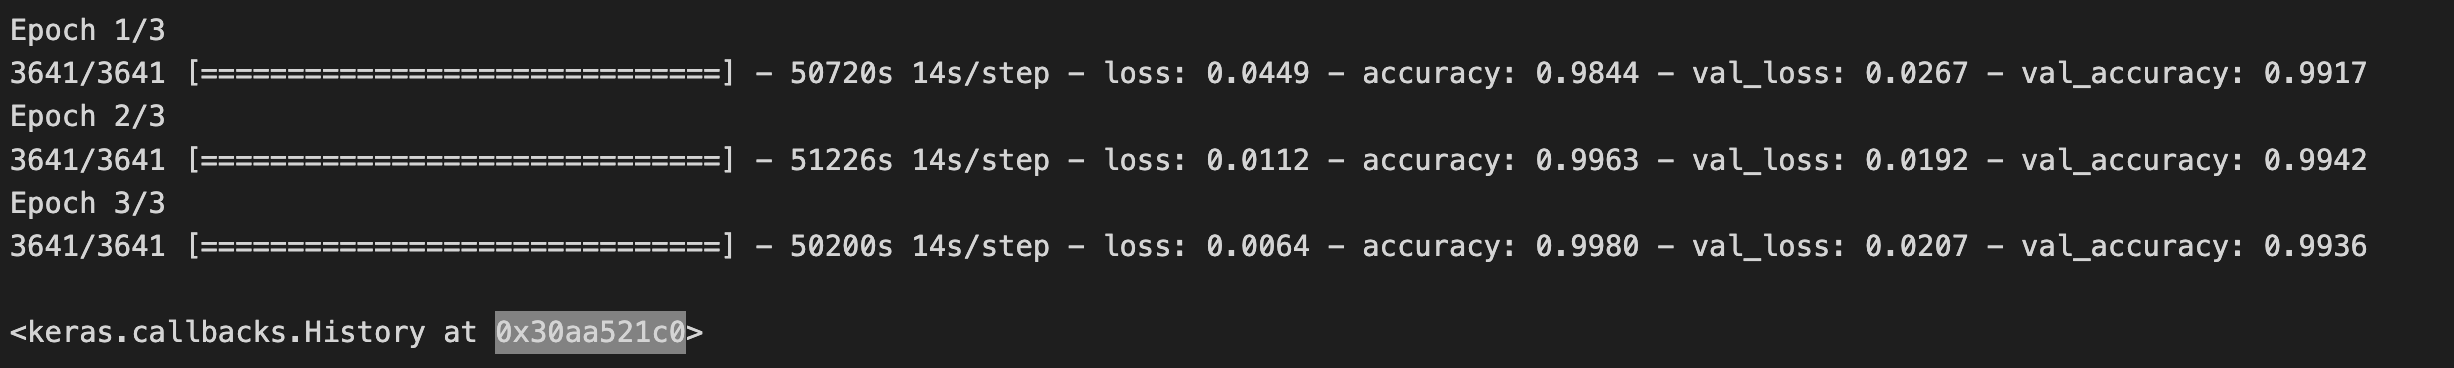

## Evaluate the model

Evaluate the model using `X_test` and `y_test` into the `text_input` layer. 

In [41]:
# model.save('email_classification_model.h5')

In [42]:
model = load_model('email_classification_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

the `evaluate` method gives the final loss and accuracy on the test set. 
- test loss: measure of the discrepancy between the model's predicted values and the actual target values in the test dataset. A lower test loss indicates that the model's predictions are closer to the true target values
- test accuracy: measure of correct predictions made by the model on the test dataset. in this case, the model correctly predicts the phishing emails 99.36% of the time. 

In [43]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test Accuracy: {accuracy}')

 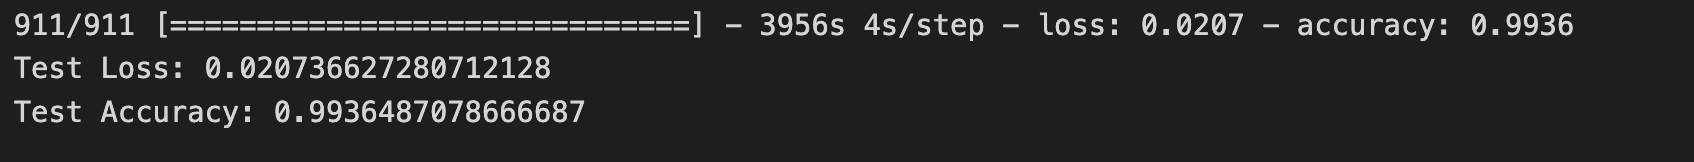

## Using the model to make predictions

In [44]:
predictions = model.predict(X_test) # Make predictions on the test data, each item in the list is a probability between 0 and 1, indicating the likelihood of the email being phishing (1 as the positive class) and (0 as the negative class)
# Convert predictions to binary outcomes
predicted_labels = (predictions > 0.5).astype("int32") # Each item is either 0 or 1; if the probability is greater than 0.5, it is 1, otherwise 0. Each element in this array is the predicted class (0 or 1) for the corresponding test example in X_test.


911/911 [==============================] - 3030s 3s/step


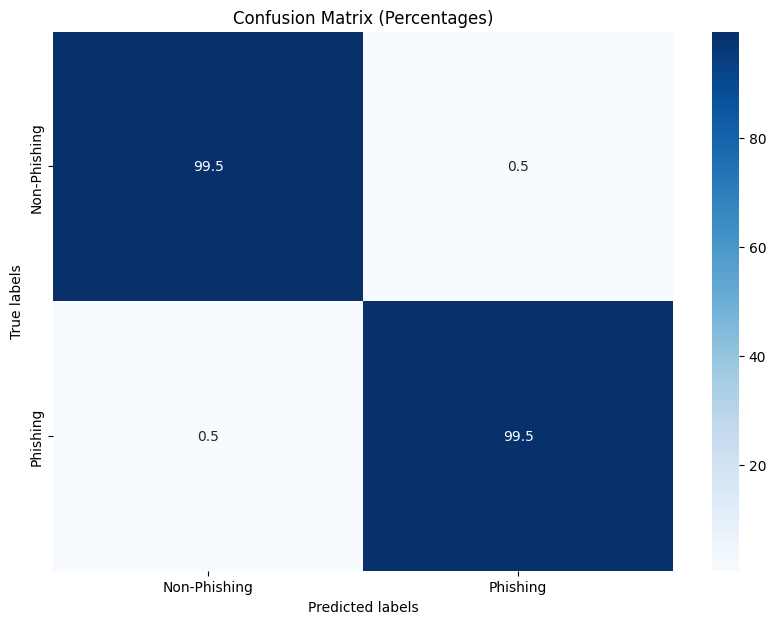

In [114]:
# # Create a confusion matrix
# cm = confusion_matrix(y_test, predicted_labels)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()
# # change the 0 and 1s to non-phishing and phishing, and add the percentages


cm = confusion_matrix(y_test, predicted_labels)

# Convert the counts to percentages relative to the true labels
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentage = cm_percentage * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(10,7))
# Use cm_percentage for annotating the heatmap
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()

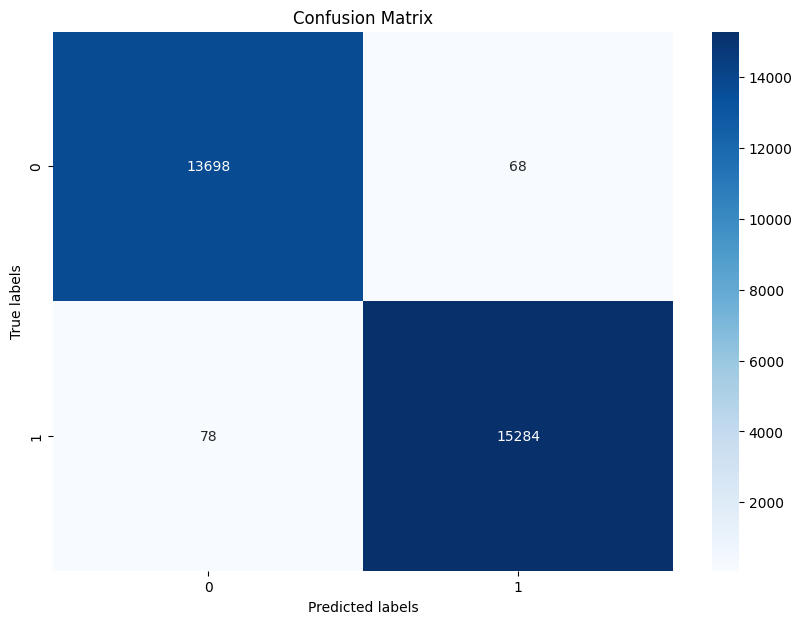

In [46]:
# Print a classification report
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13766
           1       1.00      0.99      1.00     15362

    accuracy                           0.99     29128
   macro avg       0.99      0.99      0.99     29128
weighted avg       0.99      0.99      0.99     29128



# Using the model to classify a 3 emails (positive, negative, false positive)

## Preprocess new emails in the same manner as the training data. 

Before classifying new emails, we need to preprocess them in the same manner as the training data. This means you need to concatenate the 'subject' and 'body' of your emails with a [SEP] token.

## Positive Class 

In [78]:
new_subject = "Subject: 4 color printing special  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  phone "
new_body = "( 626 ) 338 - 8090 fax : ( 626 ) 338 - 8102 e - mail : ramsey @ goldengraphix . com  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  golden graphix & printing 5110 azusa canyon rd . irwindale , ca 91706 this e - mail message is an advertisement and / or solicitation . "
new_email = new_subject + " [SEP] " + new_body

# To predict a single email
predictions = model.predict([new_email])  # Make sure new_email is in a list even if it's just one email
print(predictions)


1/1 [==============================] - 0s 181ms/step
[[0.99979883]]


## Negative Class 

In [82]:
new_subject1 = "Subject: phone call today  vince ,  there are a few matters i ' d like to discuss with you"
new_body1 = "clarification on who tony harrison reports to ( i had understood it would be  the houston crude oil weather forecast team but i am not now sure )  to let you know that joe wants to recruit a strongly mathematical  macroeconomist reporting to steve , and therefore that maureen will be  returning to houston later this month  to talk about stinson coming over for a visit  regards ,  tani"
new_email1 = new_subject1 + " [SEP] " + new_body1

prediction1 = model.predict([new_email1])

print(prediction1)

1/1 [==============================] - 0s 193ms/step
[[3.6375184e-06]]


## Positive Class 

In [84]:
new_subject2 = "Subject: 376"
new_body = "unique - logos !  your business lacks visual identity ?  marketing efforts falling short ?  invisible among a sea of competitors ?  you ' re on the right track for a solution - keep reading . . .  our professional designers specialize in the creation of custom logos and business / corporate identities . our design needs to be seen only once to gain customer attention and recognition . with one of our unique , eye - catching mages you ' ll never have to introduce yourself twice !  we promise fast turnaround and 100 % customer satisfaction . choose from as any design ideas as necessary , select as many colors as you wish , order any modifications you like , and request any format . our prices are affordable for any size of business , and get this : there are no hidden fees .  follow the link below to browse our portfolio and check out our sweet deals .  wipe the "' in '" from "' invisible '" in just a few days - with us !  http : / / lo 42 . com . ntb - soft . biz  sincerely ,  juanita rosario"
new_email2 = new_subject2 + " [SEP] " + new_body

prediction2= model.predict([new_email2])
print(prediction2)

1/1 [==============================] - 0s 193ms/step
[[0.9978123]]
